In [5]:
import glob
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind_from_stats, ttest_ind

from collections import OrderedDict
from operator import getitem

from olympus.scalarizers import Scalarizer
from olympus.surfaces import Surface

In [7]:
def get_stats(sub_df):
    stats = {}
    for method in sub_df['method'].unique():
        m_num_eval = sub_df[sub_df['method']==method]['num_iter'].values
        m_percent_eval = m_num_eval/442. * 100
        
        stats[method] = {
            'vector': m_percent_eval,
            'mean': np.mean(m_percent_eval), 
            'std': np.std(m_percent_eval),
            'nobs': m_percent_eval.shape[0],
            'stderr': np.std(m_percent_eval)/np.sqrt(m_percent_eval.shape[0]),
            'median': np.median(m_percent_eval),
            'q25': np.quantile(m_percent_eval, 0.25),
            'q75': np.quantile(m_percent_eval, 0.75),
        }
    # sort in ascending order by mean
    stats = dict(sorted(stats.items(), key = lambda d: d[1]['mean']))
        
    return stats

# helper function
def plot_traces_mean(sub_df, ax, with_stderr=True, labels=None, hue_order=None, palette=None):
    ''' plot traces according to 
    '''
    for method, label, color in zip(hue_order, labels, palette):
        traces = []
       # print('method : ', method)
        m_df = sub_df[sub_df['method']==method]
        seeds = m_df['seed'].unique()
        for seed in seeds:
            s_df = m_df[m_df['seed']==seed]
            s_df = s_df.sort_values(by='iter')

            simple_regret = s_df['simple_regret'].values
            
            traces.append(simple_regret[:50])
        traces = np.array(traces)
        mean = np.nanmean(traces, axis=0)
        stderr = np.nanstd(traces, axis=0, ddof=1)/ np.sqrt(np.shape(traces)[0]-1)
        
        x = np.arange(np.shape(traces)[1])+1
        
        
        if method  in ['RandomSearch', 'Botorch']:
            style='--'
        else:
            style='-'
        
        ax.plot(x, mean, color=color, linewidth=3, ls=style, label=label)
        if with_stderr: 
            ax.fill_between(x, y1=mean-1.96*stderr, y2=mean+1.96*stderr, alpha=0.2, color=color)
            ax.plot(x, mean-1.96*stderr, color=color, linewidth=1, alpha=0.5)
            ax.plot(x, mean+1.96*stderr, color=color, linewidth=1, alpha=0.5)

In [8]:
HUE_ORDER = [
        'RandomSearch', 
        'Botorch',
        'RGPE',
        'DKT',
]
SINGLE_TASK_PLANNERS = [
        'RandomSearch', 
        'Botorch'
]

LABELS = [
    'Random', 
    'GP',
    'RGPE',
    'DKT',
    
]
PALETTE = [
        'gray', 
        '#084c61', 
        '#93BC38',
        '#56a3a6',
]

In [ ]:
PARAM_DIM = 2
GOAL = 'minimize'

completed_task_dirs = [
    'catcamel_2d/runs',
    'catmichalewicz_2d/runs',
]

In [ ]:
all_dfs = []
for dir_ in completed_task_dirs:
    files = glob.glob(f'{dir_}/*.pkl')
    for file in files: 
        split = file.split('/')[-1].split('.')[0].split('_')
        method = split[1]
        surface = split[2]
        seed = split[3]

        if method in SINGLE_TASK_PLANNERS:
            method_type = 'regular'

        else:
            method_type = 'meta'

        res = pickle.load(open(file, 'rb'))
        params, values = res['params'], res['values']
        
        assert params.shape[0] == values.shape[0]
        
        num_iter = params.shape[0]

        param_dim = params.shape[1]
        seed_dict = {f'param_{i}': [] for i in range(PARAM_DIM)}
        seed_dict['value'] = []
        seed_dict['iter'] = []
        for iter_, (p, v) in enumerate(zip(params, values)):
            for ix, element in enumerate(p):
                seed_dict[f'param_{ix}'].append(element)
            seed_dict['value'].append(v[0])
            seed_dict['iter'].append(iter_)
        seed_dict['method'] = method
        seed_dict['seed'] = seed
        seed_dict['surface'] = surface
        seed_dict['method_type'] = method_type
        seed_dict['num_iter'] = num_iter
        seed_dict['per_explore'] = (num_iter/442)*100
        seed_df = pd.DataFrame(seed_dict)
        all_dfs.append(seed_df)

df = pd.concat(all_dfs, ignore_index=True)

df['surface'].unique()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

#----------
# CatCamel
#----------

sub_df  = df[(df['surface']=='CatCamel')]
sub_df  = sub_df[sub_df['iter']==0]

stats_catcamel = get_stats(sub_df)

_ = sns.boxplot(
        ax=axes[0], data=sub_df, 
        x='method', y='per_explore', 
        showfliers=False, order=HUE_ORDER, 
        palette=PALETTE,
)
g_ = sns.stripplot(ax=axes[0], data=sub_df, x="method", y="per_explore", 
                      order=HUE_ORDER, palette=PALETTE, 
                      edgecolor='#444444', linewidth=0.5, size=5)
axes[0].set_xticklabels(LABELS, rotation=0, fontsize=12)

axes[0].set_xlabel('')
axes[0].set_ylabel('Explored space [%]', fontsize=12)
axes[0].set_title('CatCamel (2D, 21 options)', fontsize=14)

axes[0].set_yscale('log')

#----------------
# CatMichalewicz
#----------------
print('-'*100)

sub_df  = df[(df['surface']=='CatMichalewicz')]
sub_df  = sub_df[sub_df['iter']==0]

stats_catmich = get_stats(sub_df)

_ = sns.boxplot(
        ax=axes[1], data=sub_df, 
        x='method', y='per_explore', 
        showfliers=False, order=HUE_ORDER, 
        palette=PALETTE,
)
g_ = sns.stripplot(ax=axes[1], data=sub_df, x="method", y="per_explore", 
                      order=HUE_ORDER, palette=PALETTE, 
                      edgecolor='#444444', linewidth=0.5, size=5)
axes[1].set_xticklabels(LABELS, rotation=0, fontsize=12)


axes[1].set_ylabel('')
axes[1].set_xlabel('', fontsize=12)
axes[1].set_title('CatMichalewicz (2D, 21 options)', fontsize=14)


axes[1].set_yscale('log')

plt.tight_layout()

In [ ]:
completed_task_dirs = [
    'hartmann_3D/runs',
    'gprice_2D/runs',
]
PARAM_DIMS = [3, 2]

In [ ]:
all_dfs = []

for dir_, PARAM_DIM in zip(completed_task_dirs, PARAM_DIMS):
    
    files = glob.glob(f'{dir_}/*.pkl')
    
    for file in files: 
        split = file.split('/')[-1].split('.')[0].split('_')
        method = split[1]
        surface = split[2]
        seed = split[3]

        if method in SINGLE_TASK_PLANNERS:
            method_type = 'Single task'
        else:
            method_type = 'Meta-learning'

        # special case for random sampling to make plotting easier
        if method == 'RandomSearch':
            method_type = 'Random'
            
        res = pickle.load(open(file, 'rb'))
        params, values = res['params'], res['values']

        param_dim = params.shape[1]
        seed_dict = {f'param_{i}': [] for i in range(PARAM_DIM)}
        seed_dict['value'] = []
        seed_dict['iter'] = []

        for iter_, (p, v) in enumerate(zip(params, values)):
            for ix, element in enumerate(p):
                seed_dict[f'param_{ix}'].append(element)
            seed_dict['value'].append(v[0])
            seed_dict['iter'].append(iter_)

        seed_dict['method'] = method
        seed_dict['seed'] = seed
        seed_dict['surface'] = surface
        seed_dict['method_type'] = method_type

        seed_df = pd.DataFrame(seed_dict)
        if GOAL == 'minimize':
            seed_df['cumbest'] = seed_df['value'].cummin()
        elif GOAL == 'maximize':
            seed_df['cumbest'] = seed_df['value'].cummax()

        all_dfs.append(seed_df)

df = pd.concat(all_dfs, ignore_index=True)

# compute the simple regret for each surface
df_gprice   = df[df.surface=='gprice']
df_ackleypath = df[df.surface.str.contains('AckleyPath')]
df_hartmann = df[df.surface=='hartmann']

# estimate the global optima with 10e6 random parameter point samples
df_gprice['simple_regret'] = df_gprice['cumbest'] - (-2.117014925950967)
df_hartmann['simple_regret'] = df_hartmann['cumbest'] - (-3.087079057733154)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False)


#--------------------
# GOLDSTEIN-PRICE-2D
#--------------------

axes[0].set_yscale('log')
axes[0].set_ylabel('Regret', fontsize=12)
axes[0].set_xlabel('# evaluations', fontsize=12)
axes[0].set_title('Goldstein-Price (2D)', fontsize=14)

plot_traces_mean(df_gprice, ax=axes[0])

axes[0].legend(loc='lower right', ncol=1, fontsize=12)

#-------------
# HARTMANN-3D
#-------------

axes[1].set_yscale('log')
axes[1].set_xlabel('# evaluations', fontsize=12)
axes[1].set_title('Hartmann (3D)', fontsize=14)

plot_traces_mean(df_hartmann, ax=axes[1])


plt.tight_layout()

In [9]:
completed_task_dirs = [
    'multfonseca_2d/runs',
    'multviennet_2d/runs',
]
PARAM_DIMS = [2, 2]
OBJ_DIMS = [2, 3]


In [10]:
all_dfs = []

for dir_, PARAM_DIM, OBJ_DIM in zip(completed_task_dirs, PARAM_DIMS, OBJ_DIMS):
    
    files = glob.glob(f'{dir_}/*.pkl')
    
    for file in files: 
        split = file.split('/')[-1].split('.')[0].split('_')
        method = split[1]
        surface = split[2]
        seed = split[3]

        if method in SINGLE_TASK_PLANNERS:
            method_type = 'Single task'
        else:
            method_type = 'Meta-learning'

        # special case for random sampling to make plotting easier
        if method == 'RandomSearch':
            method_type = 'Random'
            
        res = pickle.load(open(file, 'rb'))
        params, values = res['params'], res['values']

        param_dim = params.shape[1]
        seed_dict = {f'param_{i}': [] for i in range(PARAM_DIM)}
        value_dim = values.shape[1]
        for i in range(value_dim):
            seed_dict[f'value_{i}'] = []
        seed_dict['iter'] = []

        for iter_, (p, v) in enumerate(zip(params, values)):
            for ix, element in enumerate(p):
                seed_dict[f'param_{ix}'].append(element)
            for ix, element in enumerate(v):
                seed_dict[f'value_{ix}'].append(element)
            seed_dict['iter'].append(iter_)

        seed_dict['method'] = method
        seed_dict['seed'] = seed
        seed_dict['surface'] = surface
        seed_dict['method_type'] = method_type
        

        seed_df = pd.DataFrame(seed_dict)

        all_dfs.append(seed_df)

df = pd.concat(all_dfs, ignore_index=True)
df.head()

,param_0,param_1,value_0,value_1,iter,method,seed,surface,method_type,value_2
0,0.460678,0.421015,0.132878,0.928380,0,Botorch,1,MultFonseca,Single task,NaN
1,0.013593,0.335808,0.461423,0.799528,1,Botorch,1,MultFonseca,Single task,NaN
2,0.632474,0.192894,0.236609,0.926058,2,Botorch,1,MultFonseca,Single task,NaN
3,0.392695,0.960744,0.150567,0.981524,3,Botorch,1,MultFonseca,Single task,NaN
4,0.955278,0.759832,0.062341,0.992667,4,Botorch,1,MultFonseca,Single task,NaN


In [11]:
def get_traces(data, scalarizer, surface):
    ''' returns the best merit traces
    '''

    if surface == 'MultFonseca':
        objs = ['value_0', 'value_1']
    elif surface == 'MultViennet':
        objs = ['value_0', 'value_1', 'value_2']
    seeds = data.seed.unique()
    traces = []
    for seed in seeds[:3]:
        sub_df = data[data['seed']==seed]
        scalarized = scalarizer.scalarize(sub_df.loc[:, objs].values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [sub_df['value_0'].values[i] for i in trace_best_idx]
        trace1 = [sub_df['value_1'].values[i] for i in trace_best_idx]
        if surface == 'MultViennet':
            trace2 = [sub_df['value_2'].values[i] for i in trace_best_idx]
            traces.append([trace0, trace1, trace2])
        else:
            traces.append([trace0, trace1])
    return np.array(traces)


def plot_trace_mean(data, surface, method, scalarizer, obj_num=0, ax=None, color=None, label=None, use_std_err=True):
    
    sub_df = data[(data['surface']==surface)&(data['method']==method)]
        
    traces = get_traces(sub_df, scalarizer, surface)[:, obj_num, :]
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


[WARNING] Surface MultViennet is only defined with 3 objectives: setting `value_dim`=3


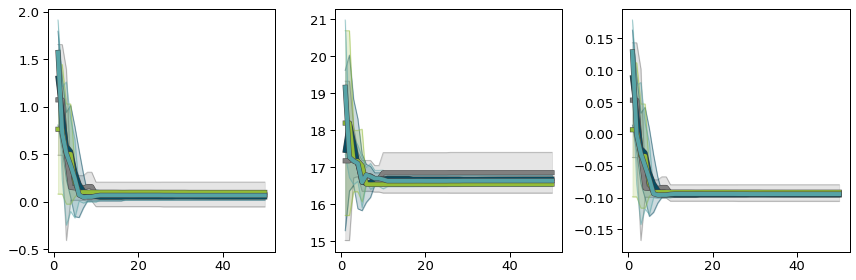

In [16]:
surface = Surface(kind='MultViennet')
scalarizer = Scalarizer(
    kind='Hypervolume',
    value_space=surface.value_space,
    goals=['min', 'min', 'min'],
)

PALETTE = [
        'gray', 
        '#084c61', 
        '#93BC38',
        '#56a3a6',
]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))


plot_trace_mean(df, 'MultViennet', 'RandomSearch', scalarizer, ax=axes[0], obj_num=0, color='gray' )
plot_trace_mean(df, 'MultViennet', 'Botorch', scalarizer, ax=axes[0], obj_num=0, color='#084c61')
plot_trace_mean(df, 'MultViennet', 'RGPE', scalarizer, ax=axes[0], obj_num=0, color='#93BC38' )
plot_trace_mean(df, 'MultViennet', 'DKT', scalarizer, ax=axes[0], obj_num=0, color='#56a3a6')


plot_trace_mean(df, 'MultViennet', 'RandomSearch', scalarizer, ax=axes[1], obj_num=1, color='gray' )
plot_trace_mean(df, 'MultViennet', 'Botorch', scalarizer, ax=axes[1], obj_num=1, color='#084c61')
plot_trace_mean(df, 'MultViennet', 'RGPE', scalarizer, ax=axes[1], obj_num=1, color='#93BC38' )
plot_trace_mean(df, 'MultViennet', 'DKT', scalarizer, ax=axes[1], obj_num=1, color='#56a3a6')

plot_trace_mean(df, 'MultViennet', 'RandomSearch', scalarizer, ax=axes[2], obj_num=2, color='gray' )
plot_trace_mean(df, 'MultViennet', 'Botorch', scalarizer, ax=axes[2], obj_num=2, color='#084c61')
plot_trace_mean(df, 'MultViennet', 'RGPE', scalarizer, ax=axes[2], obj_num=2, color='#93BC38' )
plot_trace_mean(df, 'MultViennet', 'DKT', scalarizer, ax=axes[2], obj_num=2, color='#56a3a6')


plt.tight_layout()